# work in progress... 

# Classification

Survival prediction of patients with heart failure.

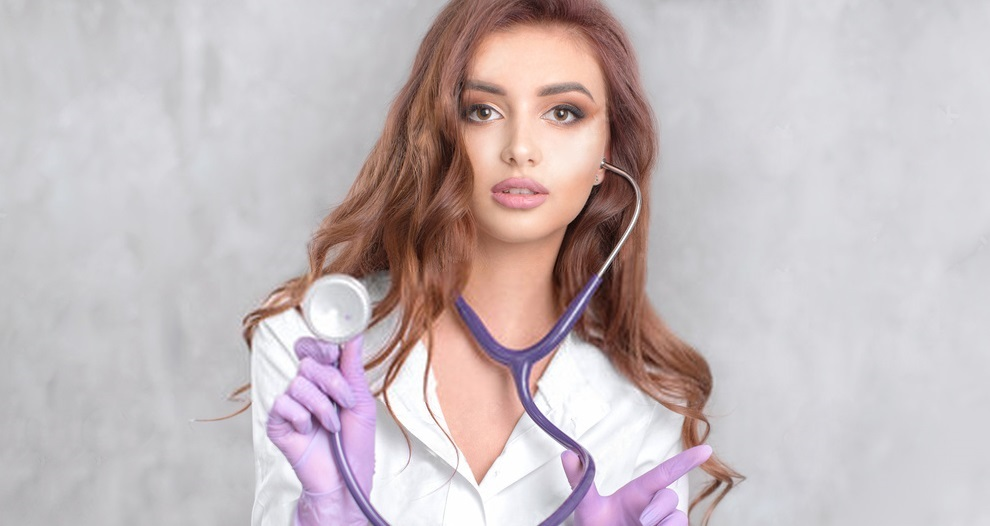

`Data Source: ` [Heart Failure](https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data) 

In this project, we will use a [dataset from Kaggle](https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data) to predict the survival of patients with heart failure from serum creatinine and ejection fraction, and other factors such as age, anemia, diabetes, and so on.

`About The Dataset:`

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

`Data Dictionary:`

1. Feature details

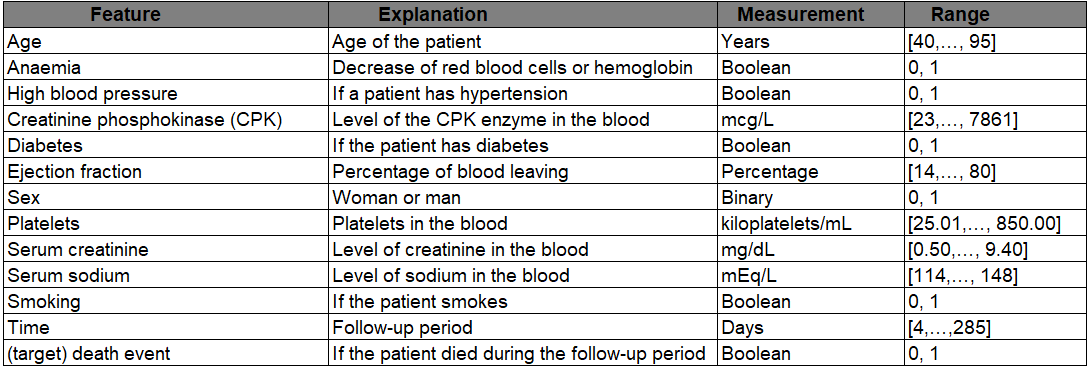

2. Boolean features
   - Sex - 0 = Female, Male = 1
   - Diabetes - 0 = No, 1 = Yes
   - Anaemia - 0 = No, 1 = Yes
   - High_blood_pressure - 0 = No, 1 = Yes
   - Smoking - 0 = No, 1 = Yes
   - DEATH_EVENT - 0 = No, 1 = Yes

3. Other informations
      - mcg/L: micrograms per liter.                  
      - mL: microliter. 
      - mEq/L: milliequivalents per litre
      - The time feature seams to be highly correlated to the death event but there is no concret information of how this               metric was measured patient by patient. Which makes it hard to use it in the analysis.

***

### Load Libraries and Data Inspection

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
# from collections import Counter
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('heart_failure.csv')
print(df.shape)
df.head()

(299, 15)


Unnamed: 0   age anaemia  creatinine_phosphokinase diabetes  \
0           0  75.0      no                       582       no   
1           1  55.0      no                      7861       no   
2           2  65.0      no                       146       no   
3           3  50.0     yes                       111       no   
4           4  65.0     yes                       160      yes   

   ejection_fraction high_blood_pressure  platelets  serum_creatinine  \
0                 20                 yes  265000.00               1.9   
1                 38                  no  263358.03               1.1   
2                 20                  no  162000.00               1.3   
3                 20                  no  210000.00               1.9   
4                 20                  no  327000.00               2.7   

   serum_sodium  sex smoking  time  DEATH_EVENT death_event  
0           130  yes      no     4            1         yes  
1           136  yes      no     6            1         yes  
2           129  yes     yes     7            1         yes  
3           137  yes      no     7            1         yes  
4           116   no      no     8            1         yes

In this dataset, we will use column `death_event` as our class label.

### Class Distribution (death_event) 

Only 32% of our samples failed to survive given of heart failure.

In [3]:
print(df['death_event'].value_counts())
# proportion
df['death_event'].value_counts() / len(df)

no     203
yes     96
Name: death_event, dtype: int64


no     0.67893
yes    0.32107
Name: death_event, dtype: float64

`We have a very small and slightly imbalance dataset`. We can't confidently use accuracy as our scoring method.

`note:` For unbalance dataset we must use recall, precision and f1 for scoring.

`recall:` number of correct prediction out of total Actual Positive. usecase if we need to reduce the False Negative like in cancer detection, we dont want our model to predict a person to be negative while the truth is positive.

`precision:` number of positive in Actual out total Positive prediction. i.e in cases we need to reduce the False Positives like in spam detection, we dont want to predict an important mail to be a spam.

### General Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                299 non-null    int64  
 1   age                       299 non-null    float64
 2   anaemia                   299 non-null    object 
 3   creatinine_phosphokinase  299 non-null    int64  
 4   diabetes                  299 non-null    object 
 5   ejection_fraction         299 non-null    int64  
 6   high_blood_pressure       299 non-null    object 
 7   platelets                 299 non-null    float64
 8   serum_creatinine          299 non-null    float64
 9   serum_sodium              299 non-null    int64  
 10  sex                       299 non-null    object 
 11  smoking                   299 non-null    object 
 12  time                      299 non-null    int64  
 13  DEATH_EVENT               299 non-null    int64  
 14  death_even

Anaemia, diabets, high_blood_pressure, sex, and smoking are in 'str' datatype. In TensorFlow with Keras, we needs to convert all the categorical features and labels into one-hot encoding vectors. 

### Define X and y
Lets define first our class and features. One advantage of Neural Network to traditional Machine Learning algorithm is that we don't need to do a feature selection, Neural Network learn from it's data and adjust features weight accordingly.

In [5]:
y = df['death_event']
# age to smoking
X = df.loc[:,'age':'smoking']
X.head(3)

age anaemia  creatinine_phosphokinase diabetes  ejection_fraction  \
0  75.0      no                       582       no                 20   
1  55.0      no                      7861       no                 38   
2  65.0      no                       146       no                 20   

  high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex smoking  
0                 yes  265000.00               1.9           130  yes      no  
1                  no  263358.03               1.1           136  yes      no  
2                  no  162000.00               1.3           129  yes     yes

### One-Hot Encoding
One hot encode our X features. Convert categorical features (anaemia, diabets, high_blood_pressure, sex, and smoking are) to one-hot encoding vectors and assign the result back to variable X.

In [6]:
X = pd.get_dummies(X)
X.head(3)

age  creatinine_phosphokinase  ejection_fraction  platelets  \
0  75.0                       582                 20  265000.00   
1  55.0                      7861                 38  263358.03   
2  65.0                       146                 20  162000.00   

   serum_creatinine  serum_sodium  anaemia_no  anaemia_yes  diabetes_no  \
0               1.9           130           1            0            1   
1               1.1           136           1            0            1   
2               1.3           129           1            0            1   

   diabetes_yes  high_blood_pressure_no  high_blood_pressure_yes  sex_no  \
0             0                       0                        1       0   
1             0                       1                        0       0   
2             0                       1                        0       0   

   sex_yes  smoking_no  smoking_yes  
0        1           1            0  
1        1           1            0  
2        1           0            1

### Split data
Splitting our train and test data to 70:30 ratio.

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 7
                                                   )

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(209, 16) (90, 16) (209,) (90,)


### Standardized 
Standardized our features.

In [38]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### Label Encoder 
Convert the class/label to integers ranging from 0 to the number of classes.

In [39]:
lencoder = LabelEncoder()
y_train = lencoder.fit_transform(y_train) 
y_test = lencoder.fit_transform(y_test)

# Show mapping
class_mapping = {l: i for i, l in enumerate(lencoder.classes_)}
class_mapping

{'no': 0, 'yes': 1}

### Designing a Deep Learning Model For Classification

In [44]:

# number of features
n_features = x_train.shape[1]

# model design
model = Sequential()

# input layer
model.add(Dense(n_features, activation='relu'))


# hidden layer 1
model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(layers.Dropout(0.15))


# output layer
model.add(Dense(1, activation='sigmoid'))

### Compile the Model
The model is optimized using the `adam` optimizer and seeks to minimize the `cross-entropy` loss. Using `Recall` as our metric. We need to reduce the False Negative rate because we dont want our model to predict a person to be negative while the truth is positive.

In [45]:
model.compile(loss='binary_crossentropy', metrics=['Recall'], optimizer='adam')

### Early Stopping

In [46]:
# reference https://keras.io/api/callbacks/early_stopping/
stop = EarlyStopping(monitor='val_loss',
                     patience=20,
                     verbose=1)

### Training Phase

In [47]:
# # fix random seed for reproducibility
# tf.random.set_seed(7)


h = model.fit(x_train, y_train, 
               validation_data= (x_test, y_test), 
               epochs=100, 
               batch_size= 64,
               verbose=1,
               callbacks=[stop]
             )

y_pred = model.predict(x_test)
y_pred = (y_pred >= 0.5)
Recall2    = recall_score(y_test, y_pred)
Recall2

Epoch 1/100
4/4 [==============================] - 1s 61ms/step - loss: 0.8137 - recall: 0.8451 - val_loss: 0.6892 - val_recall: 0.6800
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7002 - recall: 0.5493 - val_loss: 0.6111 - val_recall: 0.5200
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.6680 - recall: 0.3944 - val_loss: 0.5887 - val_recall: 0.3200
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.6488 - recall: 0.2958 - val_loss: 0.5843 - val_recall: 0.2400
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6620 - recall: 0.2113 - val_loss: 0.5812 - val_recall: 0.1200
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6506 - recall: 0.1690 - val_loss: 0.5754 - val_recall: 0.2000
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6243 - recall: 0.2676 - val_loss: 0.5688 - val_recall: 0.3200
Epoch 8/100
4/4 [==============================]

Epoch 61/100
4/4 [==============================] - 0s 11ms/step - loss: 0.4316 - recall: 0.5634 - val_loss: 0.4572 - val_recall: 0.5600
Epoch 62/100
4/4 [==============================] - 0s 11ms/step - loss: 0.4290 - recall: 0.6056 - val_loss: 0.4577 - val_recall: 0.6000
Epoch 63/100
4/4 [==============================] - 0s 11ms/step - loss: 0.4444 - recall: 0.6338 - val_loss: 0.4584 - val_recall: 0.6000
Epoch 64/100
4/4 [==============================] - 0s 11ms/step - loss: 0.4355 - recall: 0.6901 - val_loss: 0.4597 - val_recall: 0.6000
Epoch 65/100
4/4 [==============================] - 0s 10ms/step - loss: 0.4210 - recall: 0.6620 - val_loss: 0.4588 - val_recall: 0.6000
Epoch 66/100
4/4 [==============================] - 0s 10ms/step - loss: 0.4145 - recall: 0.6620 - val_loss: 0.4613 - val_recall: 0.6000
Epoch 67/100
4/4 [==============================] - 0s 10ms/step - loss: 0.4244 - recall: 0.5915 - val_loss: 0.4623 - val_recall: 0.6000
Epoch 68/100
4/4 [=======================

0.6

`Note:` We will get slightly different results if we re-run the training phase multiple times due to algorithm nature of callbacks and validation data.

Consider running the training phase a few times and compare the average outcome.

In [48]:
h.history.keys()

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])

In [49]:
# Plotting for Accuracy

# fig, axs = plt.subplots(1,2,
#                         figsize=(15, 6),
#                         gridspec_kw={'hspace': 0.5, 'wspace': 0.2}) 
# (ax1, ax2) = axs
# # Binary Entrophy
# ax1.plot(h.history['loss'], label='Train')
# ax1.plot(h.history['val_loss'], label='Validation')
# ax1.set_title('Binary Entrophy for train vs validation set')
# ax1.legend(loc="upper right")
# ax1.set_xlabel("# of epochs")
# ax1.set_ylabel("Binary Entrophy")

# # Recall
# ax2.plot(h.history['Accuracy'], label='Train')
# ax2.plot(h.history['val_Accuracy'], label='Validation')
# ax2.set_title('Recall for train vs validation set')
# ax2.legend(loc="upper right")
# ax2.set_xlabel("# of epochs")
# ax2.set_ylabel("Recall")

Text(0, 0.5, 'Recall')

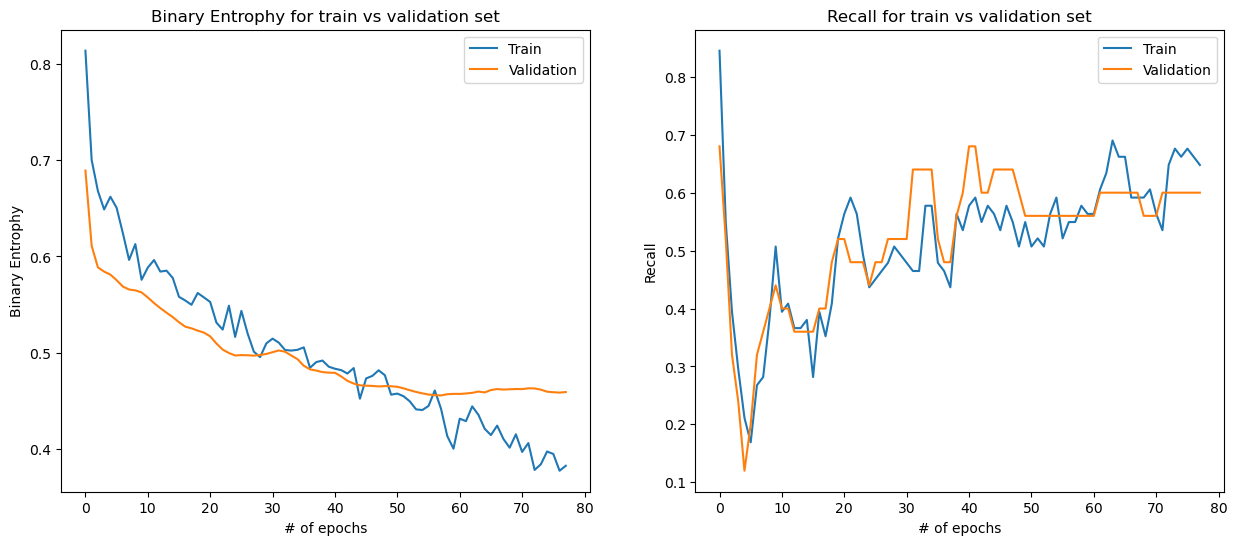

In [50]:
#plotting for Recall

fig, axs = plt.subplots(1,2,
                        figsize=(15, 6),
                        gridspec_kw={'hspace': 0.5, 'wspace': 0.2}) 
(ax1, ax2) = axs
# Binary Entrophy
ax1.plot(h.history['loss'], label='Train')
ax1.plot(h.history['val_loss'], label='Validation')
ax1.set_title('Binary Entrophy for train vs validation set')
ax1.legend(loc="upper right")
ax1.set_xlabel("# of epochs")
ax1.set_ylabel("Binary Entrophy")

# Recall
ax2.plot(h.history['recall'], label='Train')
ax2.plot(h.history['val_recall'], label='Validation')
ax2.set_title('Recall for train vs validation set')
ax2.legend(loc="upper right")
ax2.set_xlabel("# of epochs")
ax2.set_ylabel("Recall")

In [51]:
y_pred = model.predict(x_test)
y_pred = (y_pred >= 0.5)

3/3 [==============================] - 0s 1ms/step


In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        65
           1       0.68      0.60      0.64        25

    accuracy                           0.81        90
   macro avg       0.77      0.75      0.76        90
weighted avg       0.81      0.81      0.81        90



In [53]:
model_matrix = confusion_matrix(y_test, y_pred)
model_matrix

array([[58,  7],
       [10, 15]], dtype=int64)

<AxesSubplot:>

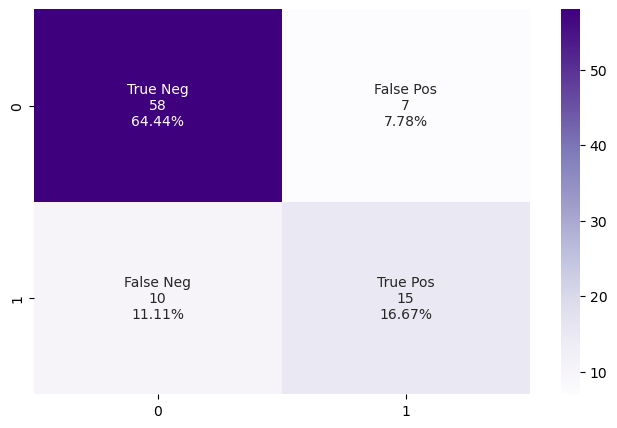

In [54]:
# Visualize
fig, ax = plt.subplots(figsize=(8,5))

# setting variables
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in model_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in model_matrix.flatten()/np.sum(model_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(model_matrix, annot=labels, fmt='', cmap='Purples')

In [55]:
Recall2    = recall_score(y_test, y_pred)
Recall2

0.6

After playing with different hyperparameters combination value, we were able to produce a model thats not overfit nor underfit and at the same time we minimize the recall score.

Let's try using GridSearchCV if we can reproduce the same hyperpameter and recall score.

# Hyperpameter Tune in
We will use GridSearchCV to find the optimal hyperparameter value, however using this method is very CPU computational expensive (there's a technique that can improve training/gridsearch speed but we will not do it here). We will do  search each hyperameter individually with minimum search value.